This project aims to create a neural network capable of estimating DoA from telecommunications signals.

To do so, the training dataset consists of In-Phase and Quadrature (IQ) samples and Angle of Arrival (AoA) measures.
IQ samples consists

In [252]:
# Import dependencies
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import keras
from keras import layers, models
import os
from keras.optimizers import Adam

In [257]:
# Set dataset path variable
signals_dataset_path = os.path.join(
    os.getcwd(), "Matlab", "Signalsbluetooth_signals_dataset_2024-02-26_23-37-54.csv"
)
# Set dataset path variable
angles_dataset_path = os.path.join(
    os.getcwd(), "Matlab", "Anglesbluetooth_signals_dataset_2024-02-26_23-37-54.csv"
)

In [258]:
# Load dataset
signal_dataset = pd.read_csv(signals_dataset_path, header=None)
signals_dataset_transposed = signal_dataset.transpose()

angles_dataset = pd.read_csv(angles_dataset_path, header=None)

data = result_df = pd.concat([angles_dataset, signals_dataset_transposed], axis=1)

In [277]:
# Extract features (IQ samples) and labels (Angles)
X_complex_str = data.iloc[:, 1:].values.astype(str)
# Replace 'i' with 'j'
X_complex_str = np.char.replace(X_complex_str, 'i', 'j')
# Convert to np.complex128
X_complex_linear = X_complex_str.astype(np.complex128)
X_complex = X_complex_linear.reshape((X_complex_linear.shape[0],4,4))
X_cov = np.array([np.cov(member, rowvar=False) for member in X_complex])
y_str = data.iloc[:, 0].values

# Separate real and imaginary parts for features
X_cov_real = np.real(X_cov)
X_cov_imag = np.imag(X_cov)

# Combine real and imaginary parts into a single array for features
X_cov_combined = np.stack((X_cov_real, X_cov_imag), axis=-1)

# Convert string representations of complex numbers to actual complex values for labels
y = np.array([int(val) for val in y_str])

# Split the combined data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_cov_combined, y, test_size=0.2, shuffle=True)

In [290]:
# Model architecture
model = models.Sequential()
# Conv2D layer
model.add(layers.Conv2D(filters=256, strides=(1, 1), kernel_size = (3,3), input_shape=X_train.shape[1:], activation='sigmoid'))
model.add(layers.BatchNormalization())

# Flatten the input for the fully connected layers
model.add(layers.Flatten())

# Fully connected layer with 512 neurons, 'relu' activation function, and batch normalization
model.add(layers.Dense(1024, activation='linear'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

# Fully connected layer with 256 neurons, 'linear' activation function, and batch normalization
model.add(layers.Dense(256, activation='linear'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

# Output layer with one value 'linear' activation function for categorical classification
model.add(layers.Dense(1, activation='linear'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Print a summary of the model architecture
model.summary()

Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_69 (Conv2D)          (None, 2, 2, 256)         4864      
                                                                 
 batch_normalization_165 (B  (None, 2, 2, 256)         1024      
 atchNormalization)                                              
                                                                 
 flatten_45 (Flatten)        (None, 1024)              0         
                                                                 
 dense_141 (Dense)           (None, 1024)              1049600   
                                                                 
 batch_normalization_166 (B  (None, 1024)              4096      
 atchNormalization)                                              
                                                                 
 dropout_96 (Dropout)        (None, 1024)            

In [291]:
import tensorflow as tf
# Train the model
history = model.fit(X_train,
                    y_train,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[tf.keras.callbacks.EarlyStopping(
                        monitor='val_loss',
                        patience=5,
                        restore_best_weights=True
                    )],
                    verbose=2)

# Evaluate the model on the test set
loss, mae = model.evaluate(X_test, y_test)
print(f'Test Mean Absolute Error: {mae}')

# Predictions on the test set
predictions = model.predict(X_test)

Epoch 1/100
724/724 - 12s - loss: 1014.5023 - mae: 25.8616 - val_loss: 549.1588 - val_mae: 18.4937 - 12s/epoch - 17ms/step
Epoch 2/100
724/724 - 11s - loss: 320.4000 - mae: 14.7295 - val_loss: 1257.0359 - val_mae: 29.8966 - 11s/epoch - 15ms/step
Epoch 3/100
724/724 - 11s - loss: 304.7614 - mae: 14.3432 - val_loss: 324.5167 - val_mae: 15.7670 - 11s/epoch - 15ms/step
Epoch 4/100
724/724 - 11s - loss: 297.8198 - mae: 14.0723 - val_loss: 4141.8379 - val_mae: 58.8699 - 11s/epoch - 15ms/step
Epoch 5/100
724/724 - 11s - loss: 292.4206 - mae: 13.9487 - val_loss: 304.2755 - val_mae: 14.0856 - 11s/epoch - 15ms/step
Epoch 6/100
724/724 - 11s - loss: 281.0099 - mae: 13.5779 - val_loss: 460.8754 - val_mae: 18.9754 - 11s/epoch - 15ms/step
Epoch 7/100
724/724 - 10s - loss: 275.0905 - mae: 13.3651 - val_loss: 751.0767 - val_mae: 23.6058 - 10s/epoch - 14ms/step
Epoch 8/100
724/724 - 11s - loss: 271.4325 - mae: 13.2650 - val_loss: 296.7005 - val_mae: 13.9646 - 11s/epoch - 16ms/step
Epoch 9/100
724/724 -

In [292]:

print("|Estimated| x |Actual| x |diff|")
for i in range(len(predictions)):
    print(f'|{int(predictions[i])}|,|{y_test[i]} | {abs(y_test[i]-int(predictions[i]))}')

#Adicionar ruido (mais de um tipo (-140 a -100db)), estimar 20 entradas de cada angulo e 

|Estimated| x |Actual| x |diff|
|63|,|78 | 15
|2|,|11 | 9
|63|,|30 | 33
|55|,|59 | 4
|58|,|63 | 5
|52|,|55 | 3
|61|,|27 | 34
|49|,|47 | 2
|55|,|59 | 4
|4|,|12 | 8
|20|,|17 | 3
|62|,|32 | 30
|52|,|54 | 2
|63|,|81 | 18
|50|,|50 | 0
|-1|,|9 | 10
|55|,|58 | 3
|-6|,|7 | 13
|-10|,|6 | 16
|15|,|16 | 1
|50|,|43 | 7
|60|,|67 | 7
|63|,|75 | 12
|52|,|41 | 11
|62|,|73 | 11
|63|,|30 | 33
|-22|,|1 | 23
|53|,|24 | 29
|51|,|53 | 2
|54|,|39 | 15
|63|,|89 | 26
|9|,|14 | 5
|63|,|86 | 23
|15|,|16 | 1
|53|,|56 | 3
|60|,|34 | 26
|62|,|73 | 11
|54|,|57 | 3
|55|,|59 | 4
|61|,|68 | 7
|60|,|67 | 7
|-6|,|7 | 13
|62|,|71 | 9
|52|,|41 | 11
|63|,|84 | 21
|55|,|38 | 17
|54|,|57 | 3
|44|,|22 | 22
|63|,|30 | 33
|2|,|11 | 9
|12|,|15 | 3
|63|,|87 | 24
|52|,|55 | 3
|-3|,|8 | 11
|59|,|65 | 6
|59|,|65 | 6
|-13|,|5 | 18
|51|,|42 | 9
|63|,|86 | 23
|-10|,|6 | 16
|50|,|43 | 7
|-20|,|2 | 22
|51|,|52 | 1
|55|,|59 | 4
|63|,|30 | 33
|60|,|66 | 6
|63|,|84 | 21
|54|,|39 | 15
|50|,|50 | 0
|49|,|47 | 2
|61|,|68 | 7
|20|,|17 | 3
|63|,|

C:\Users\Marli\AppData\Local\Temp\ipykernel_1440\2252237309.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f'|{int(predictions[i])}|,|{y_test[i]} | {abs(y_test[i]-int(predictions[i]))}')


In [293]:
len(set([int(predictions[j]) for j in range(len(predictions))]))

C:\Users\Marli\AppData\Local\Temp\ipykernel_1440\3110605697.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  len(set([int(predictions[j]) for j in range(len(predictions))]))


40

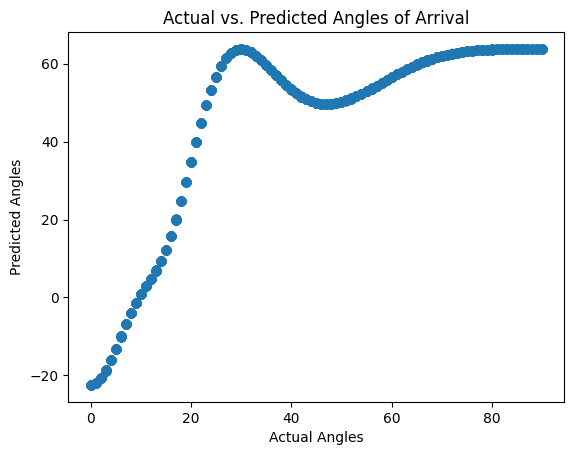

In [294]:
import matplotlib.pyplot as plt

# Visualize predictions
plt.scatter(y_test, predictions)
plt.title('Actual vs. Predicted Angles of Arrival')
plt.xlabel('Actual Angles')
plt.ylabel('Predicted Angles')
plt.show()

In [270]:
from scipy.stats import pearsonr

# Calculate the correlation coefficient
correlation, _ = pearsonr(y_test, predictions.flatten())
print(f'Correlation Coefficient: {correlation}')

Correlation Coefficient: 0.8273856655012836
